<a href="https://colab.research.google.com/github/abdullahamruf/LLM-Research/blob/main/basic_t5_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install necessary libraries (only needed in environments where they aren't already installed)
!pip install matplotlib seaborn nltk wordcloud transformers datasets scikit-learn

# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.model_selection import train_test_split
from transformers import T5Tokenizer, T5ForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, cohen_kappa_score, matthews_corrcoef, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
from google.colab import drive
drive.mount('/content/drive')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
Mounted at /content/drive


In [2]:

# Download necessary NLTK resources for tokenization
nltk.download('punkt')

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/data_to_be_cleansed.csv')

# Overview of the dataset
print("Dataset Overview:")
print(f"Shape: {df.shape}")
print("Columns:", df.columns)
print("\nFirst 5 Rows:")
print(df.head())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Calculate lengths of text and title
df['text_length'] = df['text'].astype(str).apply(len)
df['title_length'] = df['title'].astype(str).apply(len)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Dataset Overview:
Shape: (5957, 4)
Columns: Index(['Unnamed: 0', 'text', 'title', 'target'], dtype='object')

First 5 Rows:
   Unnamed: 0                                               text  \
0           0  Welcome to /r/depression's check-in post - a p...   
1           1  We understand that most people who reply immed...   
2           2  Anyone else just miss physical touch? I crave ...   
3           3  I’m just so ashamed. Everyone and everything f...   
4           4  I really need a friend. I don't even have a si...   

                                               title  target  
0  Regular check-in post, with information about ...       1  
1  Our most-broken and least-understood rules is ...       1  
2  I haven’t been touched, or even hugged, in so ...       1  
3                    Being Depressed is Embarrassing       1  
4  I'm desperate for a friend and to feel loved b...       1  

Missing Values:
Unnamed: 0      0
text          350
title           0
target          0



Text Length Summary:
        text_length  title_length
count   5957.000000   5957.000000
mean     787.263220     43.958200
std      879.580159     34.128644
min        1.000000      1.000000
25%      256.000000     23.000000
50%      553.000000     35.000000
75%     1035.000000     55.000000
max    27542.000000    300.000000


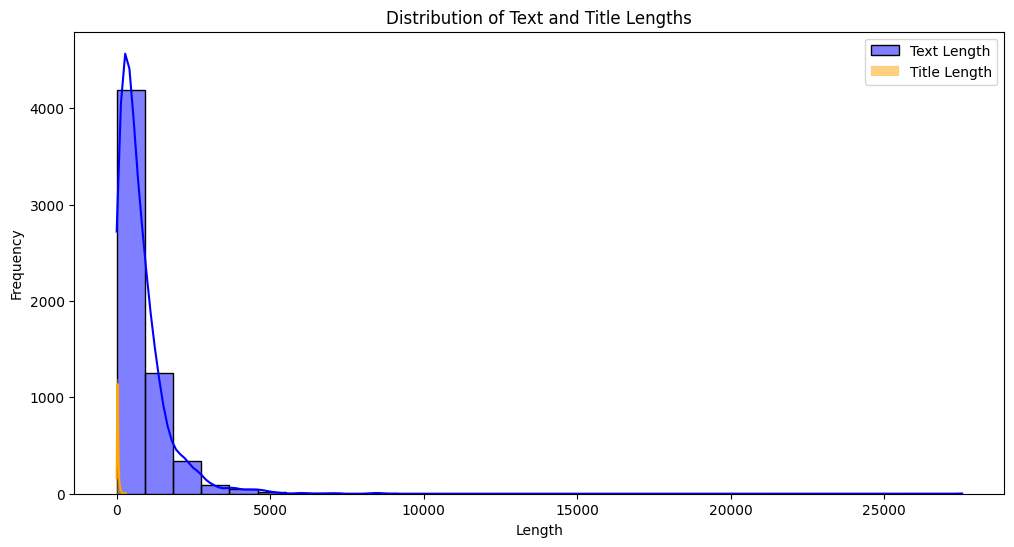

Target Distribution:
target
1    1202
3    1201
4    1188
2    1185
0    1181
Name: count, dtype: int64


In [3]:
# Summary statistics for text and title lengths
print("\nText Length Summary:")
print(df[['text_length', 'title_length']].describe())

# Visualize text and title length distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['text_length'], kde=True, bins=30, color='blue', label='Text Length')
sns.histplot(df['title_length'], kde=True, bins=30, color='orange', label='Title Length')
plt.title('Distribution of Text and Title Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Target distribution values
target_distribution = df['target'].value_counts()

print("Target Distribution:")
print(target_distribution)

In [5]:

train_texts, test_texts, train_labels, test_labels = train_test_split(df['text'], df['target'], test_size=0.2, random_state=42)

# Check the shape of the splits
print(f"Training set: {len(train_texts)} samples, Test set: {len(test_texts)} samples")

# Load T5 tokenizer
tokenizer = T5Tokenizer.from_pretrained('t5-small')

# Ensure all elements in train_texts and test_texts are strings
train_texts = train_texts.astype(str).tolist()
test_texts = test_texts.astype(str).tolist()

# Tokenize the text data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)

# Check the number of unique labels
print(f"Number of unique labels: {len(label_encoder.classes_)}")

# Convert data to PyTorch datasets
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Create train and test datasets
train_dataset = CustomDataset(train_encodings, train_labels)
test_dataset = CustomDataset(test_encodings, test_labels)

Training set: 4765 samples, Test set: 1192 samples


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Number of unique labels: 5


In [6]:
# Load T5 model for sequence classification
model = T5ForSequenceClassification.from_pretrained('t5-small', num_labels=len(label_encoder.classes_))

# Move model to GPU (if available)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Disable WANDB logging (optional)
import os
os.environ["WANDB_DISABLED"] = "true"

# Set training arguments
training_args = TrainingArguments(
    output_dir='./results',            # output directory
    num_train_epochs=100,              # number of training epochs
    per_device_train_batch_size=16,    # batch size for training
    per_device_eval_batch_size=64,     # batch size for evaluation
    warmup_steps=500,                  # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                 # strength of weight decay
    logging_dir='./logs',              # directory for storing logs
    logging_steps=10,                  # log every 10 steps
    evaluation_strategy='steps',       # perform evaluation every certain number of steps
    eval_steps=100,                    # perform evaluation every 100 steps
    save_steps=500,                    # Save checkpoint every 500 steps
    load_best_model_at_end=True,       # Load the best model at the end of training
)

# Initialize Trainer
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset
)

# Train the model
trainer.train()

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-small and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss,Validation Loss
100,1.641300,1.647611
200,1.641900,1.614542
300,1.618600,1.603876
400,1.599100,1.590119
500,1.572500,1.554632
600,1.507600,1.447259
700,1.250300,1.240361
800,1.116200,1.086626
900,1.062600,1.031147
1000,0.899600,0.994689


There were missing keys in the checkpoint model loaded: ['transformer.encoder.embed_tokens.weight', 'transformer.decoder.embed_tokens.weight'].


TrainOutput(global_step=29800, training_loss=0.21286207288603654, metrics={'train_runtime': 2540.119, 'train_samples_per_second': 187.59, 'train_steps_per_second': 11.732, 'total_flos': 1.6219650255744e+16, 'train_loss': 0.21286207288603654, 'epoch': 100.0})

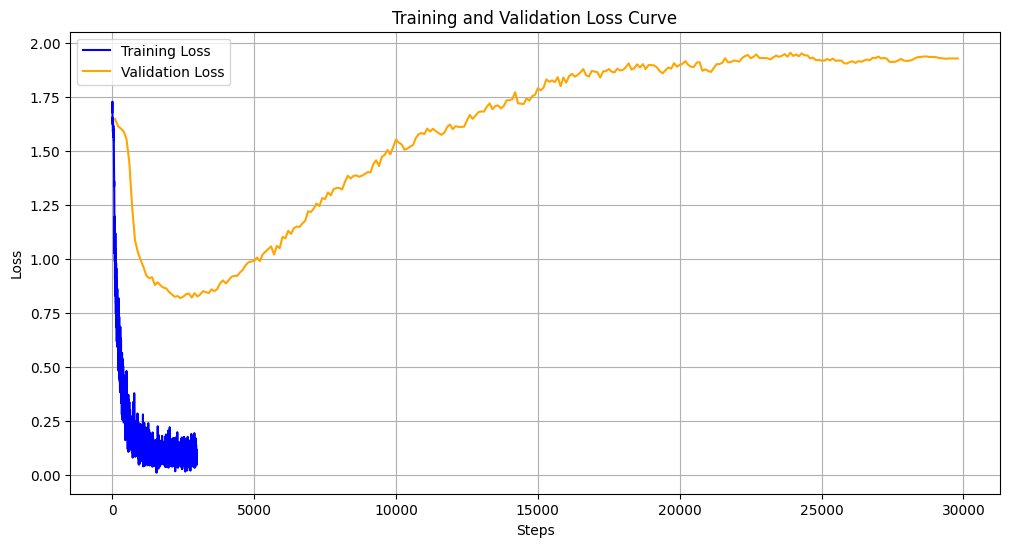

In [7]:
# Load the training log from the Trainer
logs = trainer.state.log_history

# Extract training and validation losses
train_loss = [log['loss'] for log in logs if 'loss' in log]
eval_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log]

# Create the x-axis values
train_steps = range(len(train_loss))
eval_steps = [log['step'] for log in logs if 'eval_loss' in log]

# Plot the training and validation loss curves
plt.figure(figsize=(12, 6))
plt.plot(train_steps, train_loss, label="Training Loss", color='blue')
plt.plot(eval_steps, eval_loss, label="Validation Loss", color='orange')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid()
plt.show()

In [8]:
# Evaluate the model
predictions, true_labels, _ = trainer.predict(test_dataset)

# Access the logits from the predictions tuple - the logits are the first element in the tuple
logits = predictions[0]

# Convert logits to predicted labels using argmax
pred_labels = logits.argmax(axis=-1)

# Calculate metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.7122
Precision: 0.7167
Recall: 0.7122
F1-score: 0.7129


In [9]:
# Cohen's Kappa
kappa = cohen_kappa_score(true_labels, pred_labels)

# Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(true_labels, pred_labels)

# Print both values
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")


Cohen's Kappa: 0.6400
Matthews Correlation Coefficient (MCC): 0.6407


In [11]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

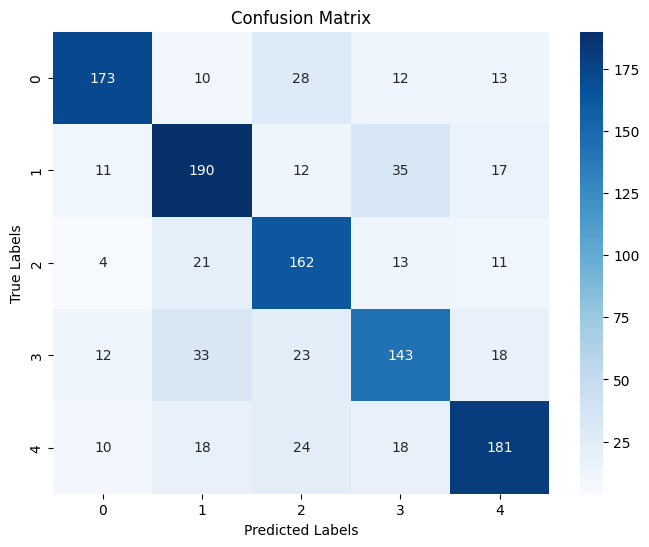

In [12]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

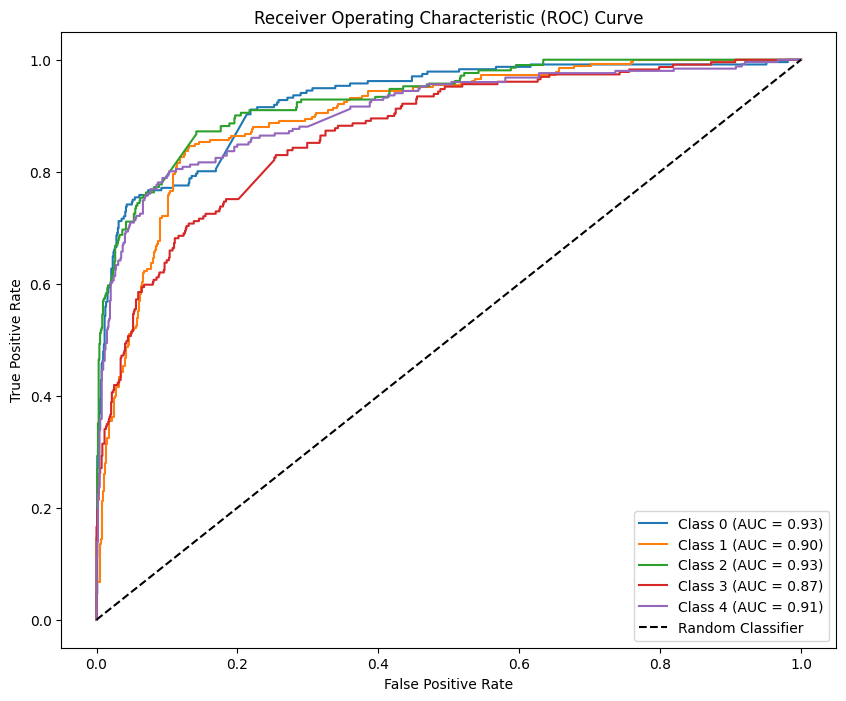

In [14]:

true_labels_binarized = label_binarize(true_labels, classes=label_encoder.classes_)

# Compute ROC curve and ROC AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

predictions_array = np.array(predictions[0])  # Convert predictions to a NumPy array

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], predictions_array[:, i]) # Using predictions_array
    roc_auc[i] = roc_auc_score(true_labels_binarized[:, i], predictions_array[:, i]) # Using predictions_array

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the random classifier line (diagonal)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
